# DATA GENERATION

In [34]:
import pandas as pd
import numpy as np

In [35]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of records
n_records = 5000

In [36]:
# Generate synthetic data
data = pd.DataFrame({
    'CustomerID': np.arange(1, n_records + 1),
    'Age': np.random.randint(18, 70, size=n_records),
    'Gender': np.random.choice(['Male', 'Female'], size=n_records),
    'ContractType': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n_records),
    'MonthlyCharges': np.round(np.random.uniform(20, 120, size=n_records), 2),
    'TotalCharges': np.round(np.random.uniform(100, 8000, size=n_records), 2),
    'TechSupport': np.random.choice(['Yes', 'No'], size=n_records),
    'InternetService': np.random.choice(['DSL', 'Fiber optic', 'No'], size=n_records),
    'Tenure': np.random.randint(1, 72, size=n_records),
    'PaperlessBilling': np.random.choice(['Yes', 'No'], size=n_records),
    'PaymentMethod': np.random.choice(['Cash','UPI','Internet Banking', 'Debit card', 'Credit card'], size=n_records),
    'Churn': np.random.choice(['Yes', 'No'], size=n_records, p=[0.2, 0.8])
})

In [37]:
# Derived features
data['average_monthly_charges'] = data['TotalCharges'] / np.where(data['Tenure'] == 0, 1, data['Tenure'])
data['customer_lifetime_value'] = data['MonthlyCharges'] * data['Tenure']

In [38]:
# Introduce missing values
data.loc[np.random.choice(data.index, size=50, replace=False), 'TotalCharges'] = np.nan

# Introduce outliers
data.loc[np.random.choice(data.index, size=10, replace=False), 'MonthlyCharges'] *= 1.5

In [39]:
# Save dataset to CSV
data.to_csv('data/customer_data.csv', index=False)

data.head()

,CustomerID,Age,Gender,ContractType,MonthlyCharges,TotalCharges,TechSupport,InternetService,Tenure,PaperlessBilling,PaymentMethod,Churn,average_monthly_charges,customer_lifetime_value
0,1,56,Male,One year,107.19,4226.00,Yes,DSL,37,Yes,Cash,No,114.216216,3966.03
1,2,69,Female,Month-to-month,88.74,4179.00,Yes,No,24,Yes,Debit card,No,174.125000,2129.76
2,3,46,Female,Month-to-month,31.16,5563.41,Yes,Fiber optic,62,Yes,Debit card,No,89.732419,1931.92
3,4,32,Male,Two year,34.77,478.61,No,No,21,Yes,Debit card,No,22.790952,730.17
4,5,60,Male,One year,62.81,5708.18,Yes,DSL,37,Yes,Debit card,Yes,154.275135,2323.97


# EXPLORATORY DATA ANALYSIS (EDA)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [41]:
data = pd.read_csv('data/customer_data.csv')

print(data.describe())

        CustomerID          Age  MonthlyCharges  TotalCharges       Tenure  \
count  5000.000000  5000.000000     5000.000000   4950.000000  5000.000000   
mean   2500.500000    43.584600       70.151094   4006.770986    36.118200   
std    1443.520003    14.919094       28.780372   2266.764015    20.404624   
min       1.000000    18.000000       20.010000    100.070000     1.000000   
25%    1250.750000    31.000000       45.640000   2035.802500    19.000000   
50%    2500.500000    43.000000       70.365000   3992.470000    36.000000   
75%    3750.250000    56.000000       94.655000   5924.025000    54.000000   
max    5000.000000    69.000000      165.105000   7999.150000    71.000000   

       average_monthly_charges  customer_lifetime_value  
count              5000.000000              5000.000000  
mean                266.685272              2542.158380  
std                 628.153316              1863.504082  
min                   1.548310                21.000000  
25%    

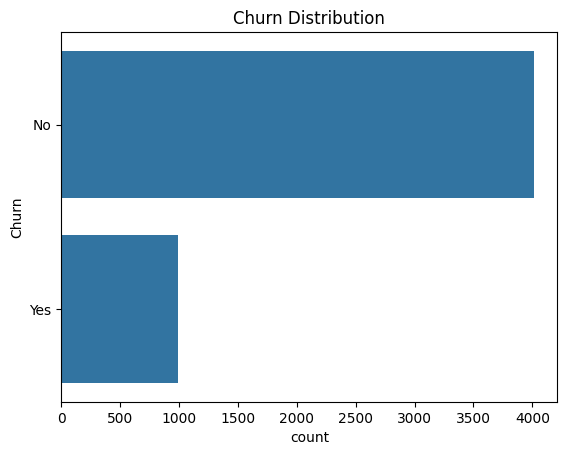

In [42]:
# Analyze churn distribution
sns.countplot(data['Churn'])
plt.title('Churn Distribution')
plt.show()

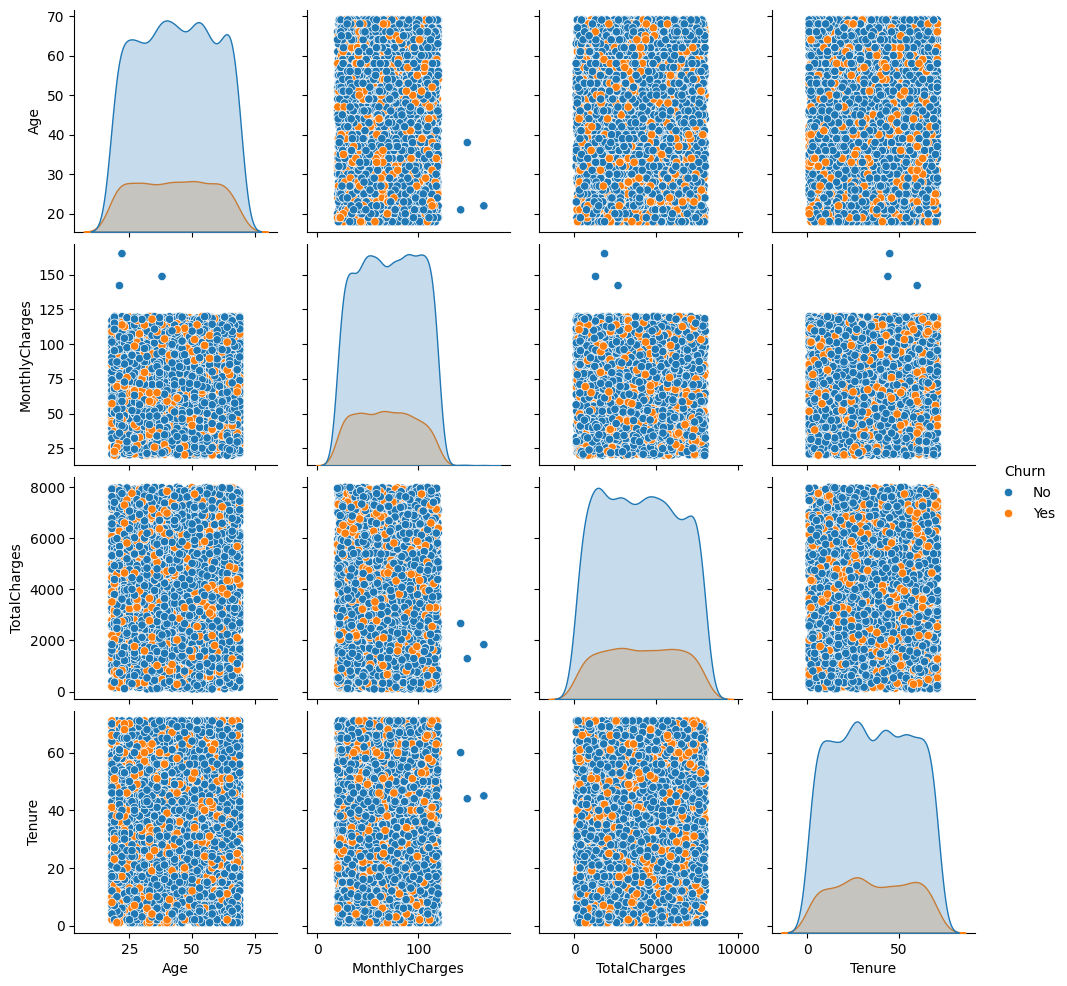

In [43]:
# Analyze numerical features
sns.pairplot(data, hue='Churn', vars=['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure'])
plt.show()

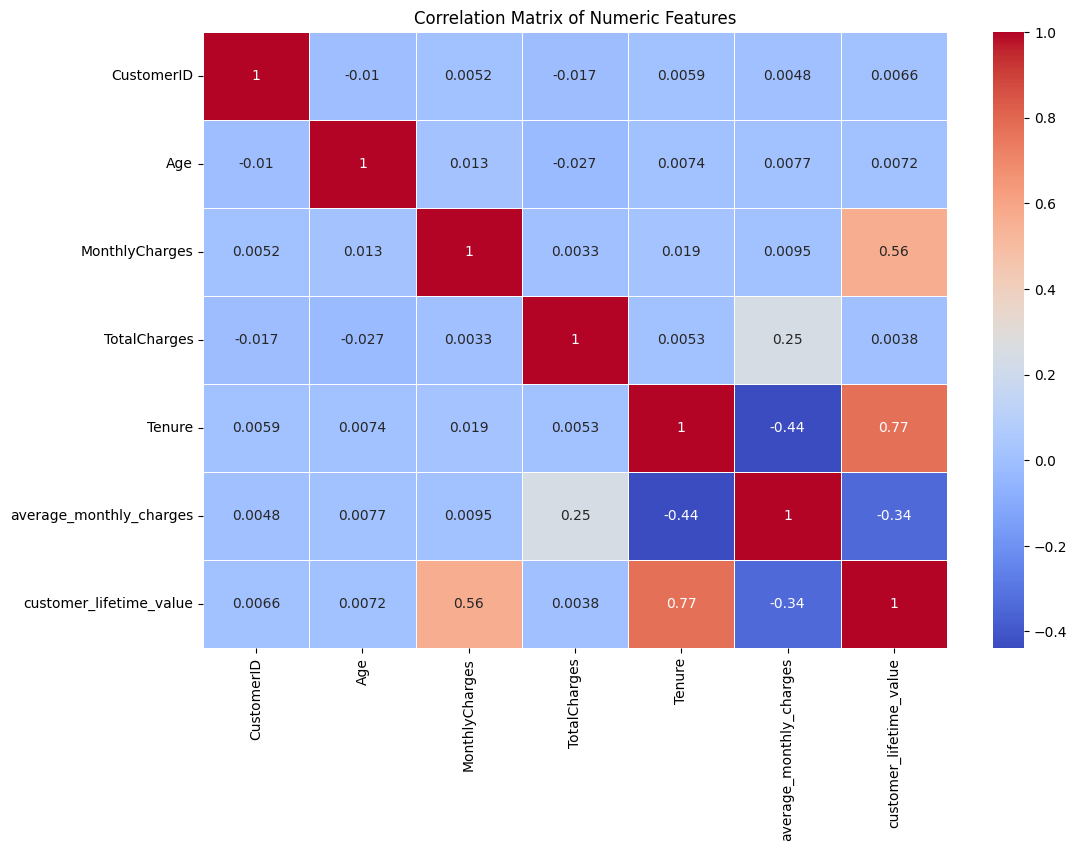

In [44]:
# Correlation matrix
numeric_cols = data.select_dtypes(include=[np.number])

corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

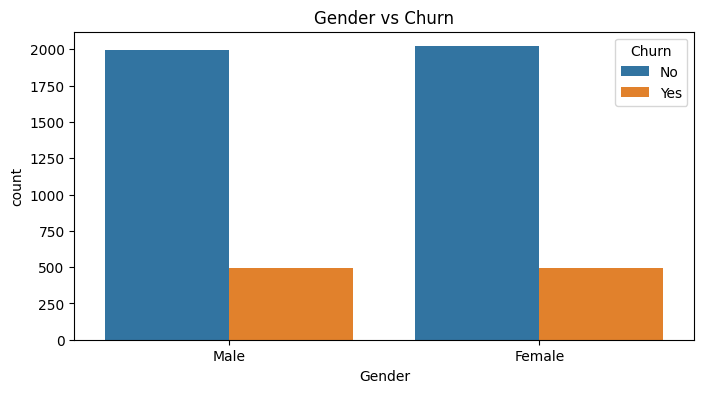

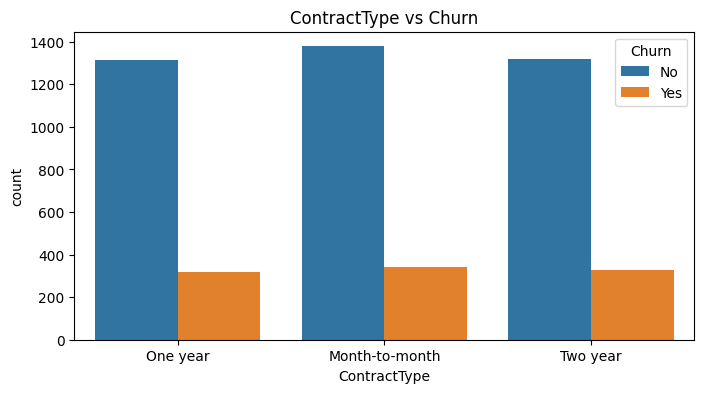

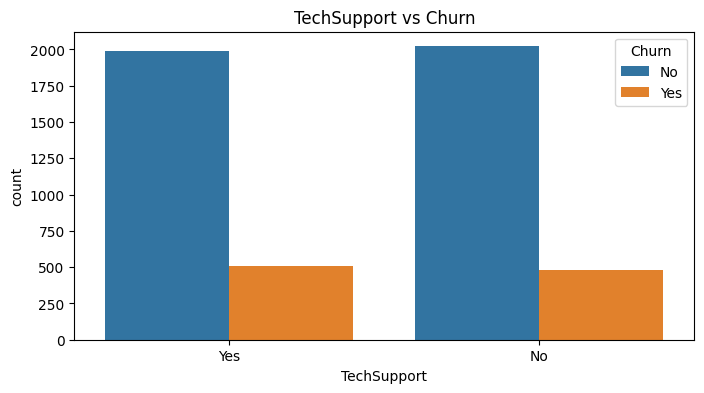

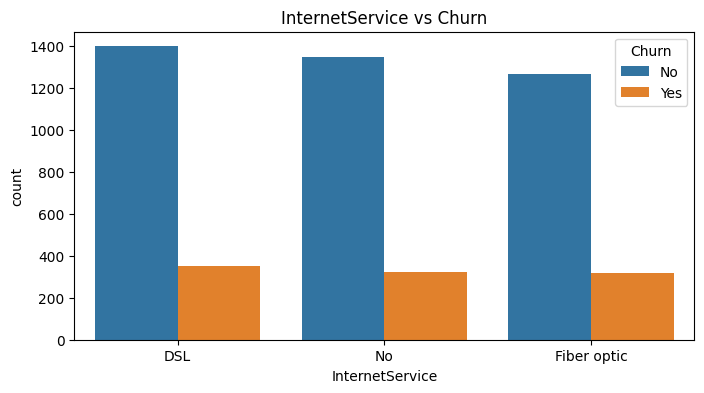

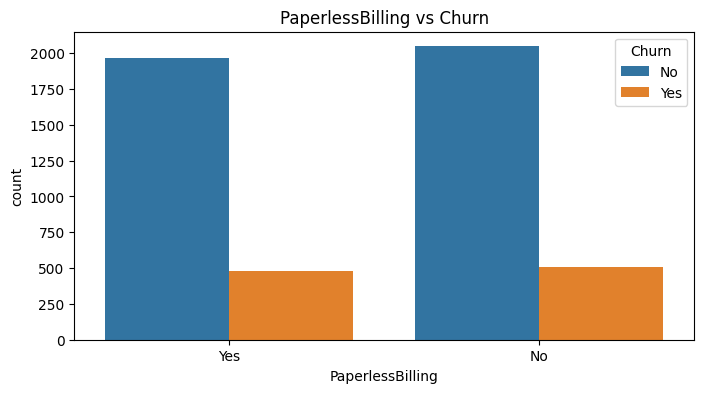

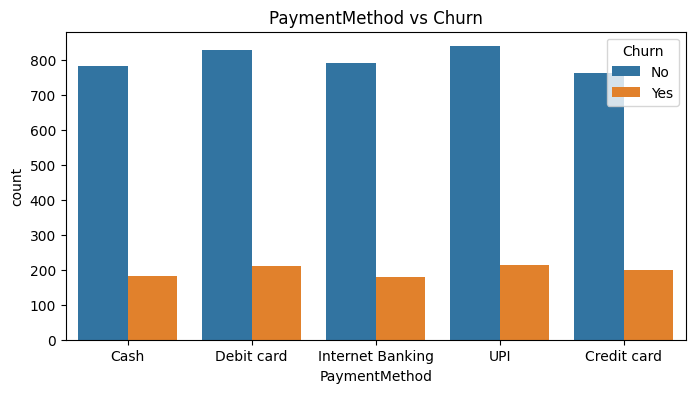

In [45]:
# Analyze categorical features
for col in ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod']:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f'{col} vs Churn')
    plt.show()

# DATA PREPROCESSING

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [47]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
data['TotalCharges'] = imputer.fit_transform(data[['TotalCharges']])


In [48]:
# Encode categorical features
label_encoders = {}
for col in ['Gender', 'ContractType', 'TechSupport', 'InternetService', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [49]:
# Feature scaling
scaler = StandardScaler()
data[['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'average_monthly_charges', 'customer_lifetime_value']] = \
    scaler.fit_transform(data[['Age', 'MonthlyCharges', 'TotalCharges', 'Tenure', 'average_monthly_charges', 'customer_lifetime_value']])

In [50]:
# Split dataset
X = data.drop(columns=['CustomerID', 'Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [51]:
X_train.shape, X_test.shape

((4000, 12), (1000, 12))

# FEATURE ENGINEERING

In [52]:
# Example feature engineering
X_train['monthly_to_tenure_ratio'] = X_train['MonthlyCharges'] / np.where(X_train['Tenure'] == 0, 1, X_train['Tenure'])
X_test['monthly_to_tenure_ratio'] = X_test['MonthlyCharges'] / np.where(X_test['Tenure'] == 0, 1, X_test['Tenure'])


# MODEL BUILDING

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

LOGISTIC REGRESSION

In [54]:
# Train Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [55]:
# Evaluate Logistic Regression
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_logreg):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_logreg):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_logreg):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]):.2f}")

Logistic Regression Accuracy: 0.80
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
ROC AUC: 0.48


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


DECISION TREE

In [56]:
# Train Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [57]:
# Evaluate Decision Tree
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_tree):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1]):.2f}")

Decision Tree Accuracy: 0.80
Precision: 0.44
Recall: 0.02
F1-Score: 0.04
ROC AUC: 0.49


# MODEL SELECTION AND EVALUATION

In [58]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


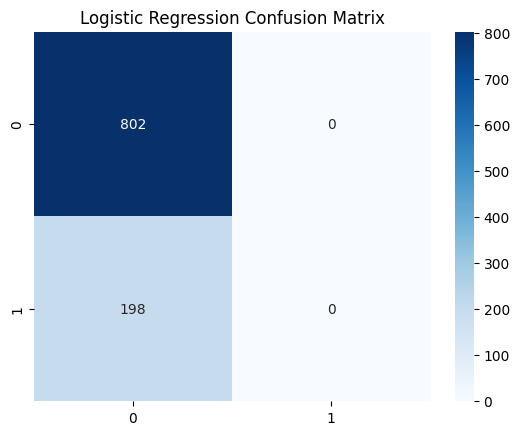

In [59]:
# Confusion Matrix for Logistic Regression
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

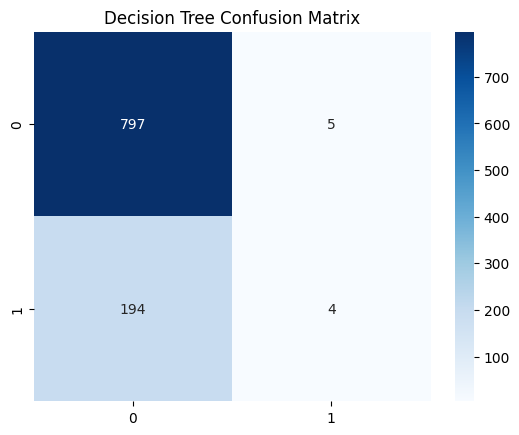

In [60]:
# Confusion Matrix for Decision Tree
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

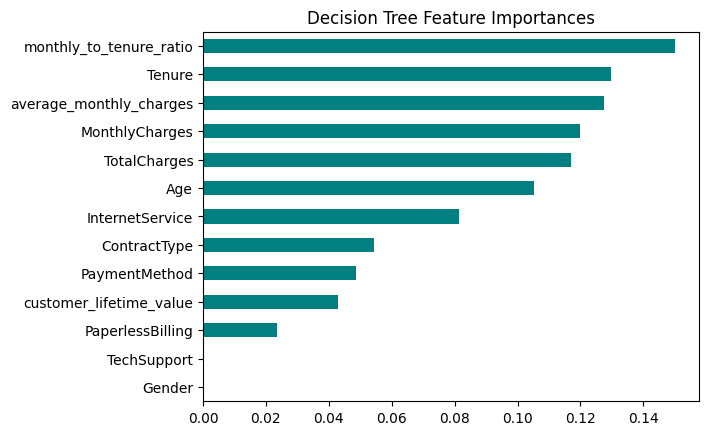

In [61]:
# Feature Importance for Decision Tree
importances = pd.Series(tree.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', color='teal')
plt.title('Decision Tree Feature Importances')
plt.show()

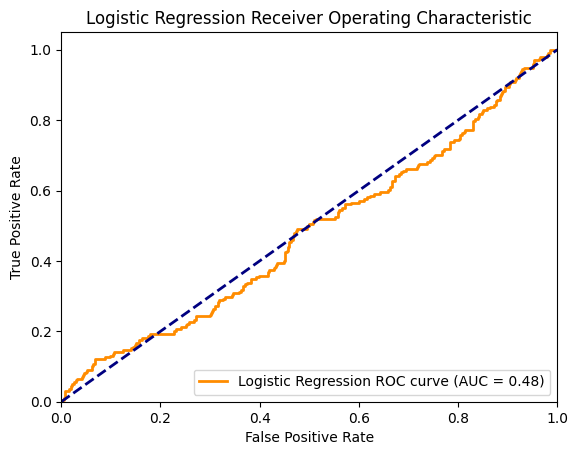

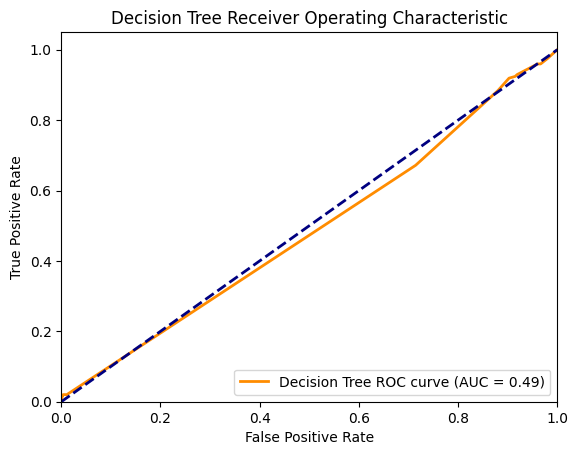

In [62]:
def plot_roc(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
# Plot ROC Curves for both models
plot_roc(logreg, X_test, y_test, 'Logistic Regression')
plot_roc(tree, X_test, y_test, 'Decision Tree')


# DEPLOYMENT